In [2]:
# 1. Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from torchvision import transforms
from google.colab import files
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [3]:
# Define transformations for data augmentation and normalization
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64 pixels
    transforms.RandomHorizontalFlip(),  # Flip images randomly
    transforms.RandomRotation(15),  # Small rotations
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Brightness and contrast
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize([0.5], [0.5])  # Normalize pixel values
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load datasets
from google.colab import drive
drive.mount('/content/drive')


dataset_path = "/content/drive/My Drive/dataset"  # Update this path based on where your dataset is

train_dataset = datasets.ImageFolder(os.path.join(dataset_path, "Training"), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(dataset_path, "Validation"), transform=test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(dataset_path, "Testing"), transform=test_transforms)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print class labels
print("Class Labels: ", train_dataset.classes)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Class Labels:  ['Fake', 'Real']


In [4]:
# Define CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)  # Binary classification (Fake/Real)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate the model
model = CNNModel()


In [5]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Best for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

# Learning rate scheduler to reduce learning rate when loss stops improving
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")

    scheduler.step()  # Adjust learning rate

print("Training Complete!")


Epoch [1/20], Loss: 0.2468, Accuracy: 96.29%
Epoch [2/20], Loss: 0.1523, Accuracy: 96.87%
Epoch [3/20], Loss: 0.1401, Accuracy: 96.87%
Epoch [4/20], Loss: 0.1508, Accuracy: 96.87%
Epoch [5/20], Loss: 0.1431, Accuracy: 96.87%
Epoch [6/20], Loss: 0.1338, Accuracy: 96.87%
Epoch [7/20], Loss: 0.1270, Accuracy: 96.87%
Epoch [8/20], Loss: 0.1218, Accuracy: 96.87%
Epoch [9/20], Loss: 0.1211, Accuracy: 96.87%
Epoch [10/20], Loss: 0.1274, Accuracy: 96.87%
Epoch [11/20], Loss: 0.1167, Accuracy: 96.87%
Epoch [12/20], Loss: 0.1129, Accuracy: 96.87%
Epoch [13/20], Loss: 0.1340, Accuracy: 96.87%


In [1]:
import os
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set dataset path in Google Drive
dataset_path = "/content/drive/My Drive/dataset"  # Update if needed

# Define Image Transformations (Same as training)
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to match model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

# Load Validation Dataset from Google Drive
val_dataset = datasets.ImageFolder(os.path.join(dataset_path, "Validation"), transform=transform)
validation_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Define Device (Use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to Validate Model
def validate_model(model, validation_loader, device):
    model.to(device)
    model.eval()  # Set model to evaluation mode

    y_true = []
    y_pred = []
    y_probs = []

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)  # Convert logits to probabilities
            predicted_classes = torch.argmax(probabilities, dim=1)  # Get predicted class

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted_classes.cpu().numpy())
            y_probs.extend(probabilities[:, 1].cpu().numpy())  # Probability of "Real"

    # Compute Metrics
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)

    # Print Results
    print("\nModel Validation Results:")
    print(f" Accuracy: {accuracy:.2f}%")
    print(f" Precision: {precision:.2f}")
    print(f" Recall: {recall:.2f}")
    print(f" F1 Score: {f1:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, precision, recall, f1

# Run Validation Test
validate_model(model, validation_loader, device)


Mounted at /content/drive


NameError: name 'model' is not defined

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch [1/10], Loss: 0.8677, Accuracy: 57.58%
Epoch [2/10], Loss: 0.7799, Accuracy: 40.91%
Epoch [3/10], Loss: 0.7028, Accuracy: 40.91%
Epoch [4/10], Loss: 0.6986, Accuracy: 62.12%
Epoch [5/10], Loss: 0.6891, Accuracy: 59.09%
Epoch [6/10], Loss: 0.6844, Accuracy: 60.61%
Epoch [7/10], Loss: 0.6861, Accuracy: 72.73%
Epoch [8/10], Loss: 0.6657, Accuracy: 69.70%
Epoch [9/10], Loss: 0.6092, Accuracy: 74.24%
Epoch [10/10], Loss: 0.8076, Accuracy: 59.09%


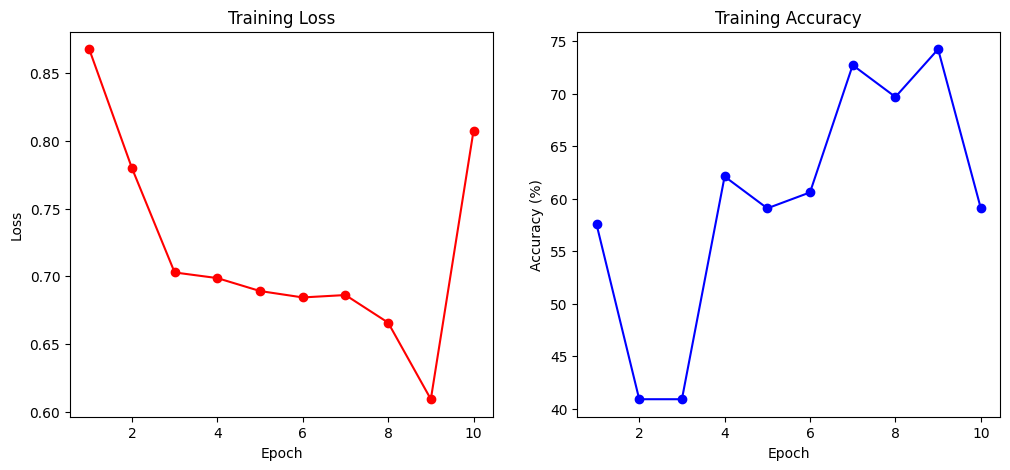

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set dataset path in Google Drive
dataset_path = "/content/drive/My Drive/dataset"  # Update if needed

# Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to match model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

# Load Training Dataset
train_dataset = datasets.ImageFolder(os.path.join(dataset_path, "Training"), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define Device (Use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Model (Example CNN)
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Adjust based on input size
        self.fc2 = nn.Linear(128, 2)  # Two classes: Fake, Real

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize Model
model = CNNModel().to(device)

# Define Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop with Accuracy Tracking
num_epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    y_true = []
    y_pred = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute Accuracy
        predicted_classes = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted_classes.cpu().numpy())

    # Calculate average loss & accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = accuracy_score(y_true, y_pred) * 100

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Plot Training Loss & Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy")

plt.show()


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 13.33%


In [ ]:
# Save model
torch.save(model.state_dict(), "fake_real_model.pth")

# Load model for later use
model.load_state_dict(torch.load("fake_real_model.pth"))
model.eval()


<ipython-input-15-db13e7c7feb8>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fake_real_model.pth"))


CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


 Model Evaluation Metrics 
 Accuracy: 13.33%
 Precision: 0.13
 Recall: 1.00
 F1 Score: 0.24
 ROC-AUC Score: 0.69


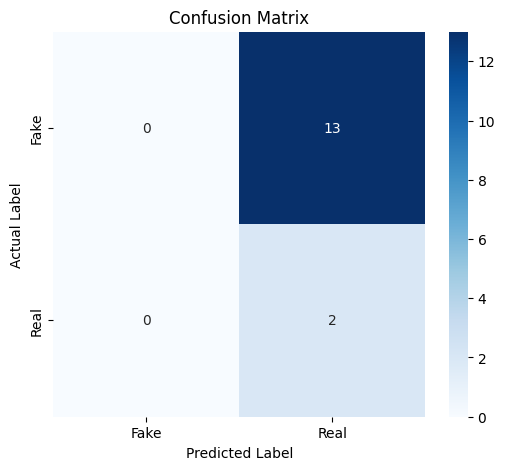

In [ ]:
# Set model to evaluation mode
model.eval()

y_true = []
y_pred = []
y_probs = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        output = model(images)

        # Convert outputs to probabilities using Softmax
        probabilities = F.softmax(output, dim=1)

        # Predicted class (Fake or Real)
        predicted_classes = torch.argmax(probabilities, dim=1)

        # Append actual labels and predictions
        y_true.extend(labels.cpu().numpy())  # Convert tensors to NumPy
        y_pred.extend(predicted_classes.cpu().numpy())
        y_probs.extend(probabilities[:, 1].cpu().numpy())  # Probability of class "Real"

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_probs)

# Print results
print("\n Model Evaluation Metrics ")
print(f" Accuracy: {accuracy:.2f}%")
print(f" Precision: {precision:.2f}")
print(f" Recall: {recall:.2f}")
print(f" F1 Score: {f1:.2f}")
print(f" ROC-AUC Score: {roc_auc:.2f}")

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:

# Upload the image once
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get the uploaded image name

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict(model, transform):
    model.eval()  # Set model to evaluation mode

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)  # Move image to the same device as model

    # Make prediction
    with torch.no_grad():
        output = model(image)
        probabilities = torch.softmax(output, dim=1)
        predicted_class_idx = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, predicted_class_idx].item()

    # Define class labels
    class_names = ["Fake", "Real"]
    predicted_label = class_names[predicted_class_idx]

    print(f"Prediction: {predicted_label} (Confidence: {confidence:.2f})")
    return predicted_label

# Example usage:
predict(model, test_transforms)


Saving 2000_s8.jpg to 2000_s8 (1).jpg
Prediction: Real (Confidence: 0.62)


'Real'